In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class BalckJack:
    def __init__(self, dealer_stick_at=17, player_stick_at=20, gamma=1):
        self.dealer_stick_at = dealer_stick_at
        self.player_stick_at = player_stick_at
        self.gamma = gamma
            
    def reset(self):
        self.action_space = {'hit':0, 'stick':1}
        self.rewards = {'win':1, 'lose':-1, 'draw':0}
        self.cards = np.array(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'])
        self.policy_player = np.zeros(22, dtype=np.int32)
        for i in range(self.player_stick_at, 22):
            self.policy_player[i] = self.action_space['stick']
        self.policy_dealer = np.zeros(22, dtype=np.int32)
        for i in range(self.dealer_stick_at, 22):
            self.policy_dealer[i] = self.action_space['stick']

        player_ace_num = 0
        player_cards = []
        for i in range(2):
            card, ace = self._get_card()
            player_cards.append(card)
            player_ace_num += ace
        player_card_sum, player_ace_num = self._check_ace(sum(player_cards), player_ace_num)
        dealer_current_card, _ = self._get_card()

        return [player_ace_num > 0, player_card_sum, dealer_current_card]

    def _get_card(self):
        card = np.random.choice(self.cards)
        if card == 'A':
            return 11, 1 # count ace as 11, number of ace
        elif card in ['J', 'Q', 'K']:
            return 10, 0
        else:
            return int(card), 0

    def _check_ace(self, card_sum, ace_num):
        while card_sum > 21 and ace_num > 0:
            card_sum -= 10
            ace_num -= 1
        return card_sum, ace_num

    def _result(self, player_sum, dealer_sum):
        if player_sum == 21:
            if dealer_sum != 21:
                return 'win'
            else:
                return 'draw'
        elif player_sum < 21:
            if dealer_sum < 21:
                if abs(21 - player_sum) < abs(21 - dealer_sum):
                    return 'win'
                elif abs(21 - player_sum) == abs(21 - dealer_sum):
                    return 'draw'
                else:
                    return 'lose'
            elif dealer_sum == 21:
                return 'lose'
            else:
                return 'win'
        else:
            return 'lose'    

    def play(self, state, policy_evaluated=None):
        trajectory = []
        usable_ace, player_card_sum, dealer_card = state
        player_ace_num = int(usable_ace)
        reward = 0

        # player
        while True:      
            if policy_evaluated is None: 
                player_action = self.policy_player[player_card_sum]
            else:
                dealer_card_reset = 1 if dealer_card == 11 else dealer_card
                player_action = policy_evaluated[player_ace_num, player_card_sum, dealer_card_reset]
            trajectory.append([state, player_action, reward])
            if player_action == self.action_space['stick']:
                break
            player_new_card, player_ace = self._get_card()
            player_card_sum, player_ace_num = self._check_ace(player_card_sum + player_new_card, player_ace_num + player_ace)
            if player_card_sum > 21:
                break
            state = [player_ace_num > 0, player_card_sum, dealer_card]


        # dealer
        dealer_card_sum = dealer_card
        dealer_ace_num = 1 if dealer_card == 11 else 0
        while True:
            dealer_action = self.policy_dealer[dealer_card_sum]
            if dealer_action == self.action_space['stick']:
                break
            dealer_new_card, dealer_ace = self._get_card()
            dealer_card_sum, dealer_ace_num = self._check_ace(dealer_card_sum + dealer_new_card, dealer_ace_num + dealer_ace)
            if dealer_card_sum > 21:
                break

        reward = self.rewards[self._result(player_card_sum, dealer_card_sum)]
        trajectory[-1][-1] = reward

        return trajectory
  

In [3]:
def monte_carlo_first_visit(episodes): 
    V = np.zeros([2, 22, 11]) # usable ace, player's current sum <=21, dealer's card (A~10)
    Returns = np.zeros([2, 22, 11])
    count = np.ones([2, 22, 11])
    black_jack = BalckJack()
    GAMMA = black_jack.gamma

    for _ in tqdm(range(episodes)):
        visited_state = []
        state = black_jack.reset()
        trajectory = black_jack.play(state)

        G = 0 
        for S, A, R in trajectory[::-1]:
            G = GAMMA * G + R
            if S not in visited_state:
                usable_ace, player_sum, dealer_current_card = S
                dealer_card = 1 if dealer_current_card == 11 else dealer_current_card
                Returns[int(usable_ace), player_sum, dealer_card] += G
                count[int(usable_ace), player_sum, dealer_card] += 1
                V = Returns / count
                visited_state.append(S)
    return V


def monte_carlo_exploring_start(episodes):
    Q = np.zeros([2, 22, 11, 2]) # Q(s, a)
    Returns = np.zeros([2, 22, 11, 2]) # Returns(s, a)
    count = np.ones([2, 22, 11, 2])
    black_jack = BalckJack()
    GAMMA = black_jack.gamma

    # init a random policy
    POLICY = (np.random.rand(np.prod([2, 22, 11])) > 0.5).astype(int)
    POLICY = POLICY.reshape([2, 22, 11])

    for _ in tqdm(range(episodes)):
        visited_state_action = []
        state = black_jack.reset()
        trajectory = black_jack.play(state, POLICY)

        G = 0 
        for S, A, R in trajectory[::-1]:
            G = GAMMA * G + R
            if S not in visited_state_action:
                usable_ace, player_sum, dealer_current_card = S
                dealer_card = 1 if dealer_current_card == 11 else dealer_current_card
                Returns[int(usable_ace), player_sum, dealer_card, A] += G
                count[int(usable_ace), player_sum, dealer_card, A] += 1
                Q = Returns / count

                state_action_values  = Q[int(usable_ace), player_sum, dealer_card]
                optimal_action = np.random.choice([action for action, value in enumerate(state_action_values) if value == np.max(state_action_values)])
                POLICY[int(usable_ace), player_sum, dealer_card] = optimal_action
                visited_state_action.append([S, A])
    return Q



In [4]:
def plot_figure_3d(state_values, ax, label=None, title=None):
    x = np.outer(np.arange(10), np.ones(10))
    y = x.copy().T
    z = np.flipud(state_values[12:, 1:])
    x_ticks = ['12', '21']
    y_ticks = ['A', '10']
    z_ticks = ['-1', '1']

    ax.plot_surface(x, y, z, cmap ='viridis')
    ax.xaxis.set_major_locator(ticker.FixedLocator([0, 10]))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.FixedLocator([0, 10]))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.FixedLocator([-1, 1]))

    ax.set_xlim(-0.2, 10.2)
    ax.set_ylim(-0.2, 10.2)
    ax.set_zlim(-1.01, 1.01)

    ax.set_xticklabels(reversed(x_ticks))
    ax.set_yticklabels(y_ticks)
    ax.set_zticklabels(z_ticks)
    ax.set_xlabel('Player sum')
    ax.set_ylabel('Dealer showing')
    ax.set_zlabel(label, rotation=20)
    ax.set_title(title)
    
    # ax.view_init(elev=0, azim=90)
    ax.view_init(elev=30, azim=45)
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

def plot_figure_heatmap(policy, ax, label=None, title=None):
    x_ticks = [str(lbl) for lbl in range(1, 11)]
    x_ticks[0] = 'A'
    y_ticks = [str(lbl) for lbl in range(11, 22)]
    y_ticks.reverse()
    
    sns.heatmap(np.flipud(policy[11:, 1:]), cmap="YlGnBu", ax=ax)
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_ylabel(label)
    ax.set_title(title)

In [5]:
def example_5_1():
    state_values_1 = monte_carlo_first_visit(10000)
    state_values_2 = monte_carlo_first_visit(500000)
    return state_values_1, state_values_2

state_values_1, state_values_2 = example_5_1()

100%|██████████| 500000/500000 [00:29<00:00, 17081.18it/s]


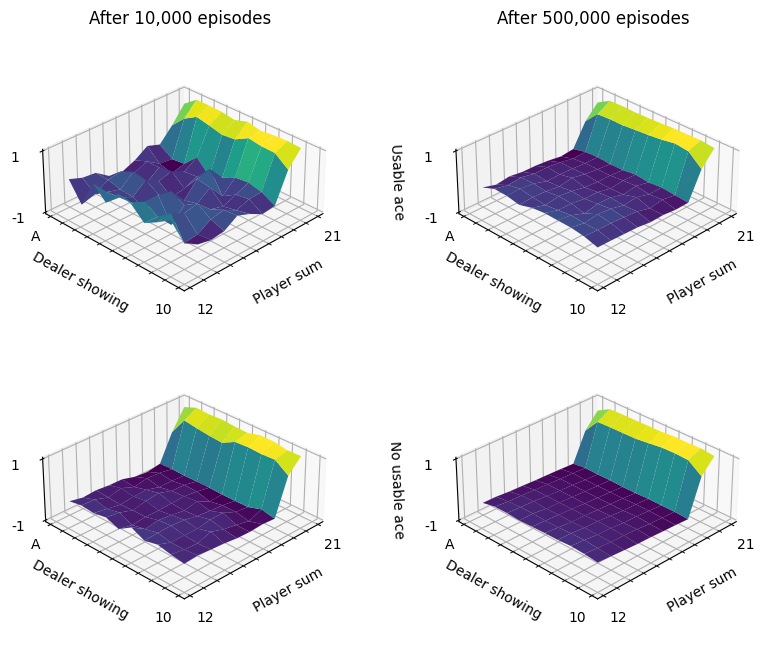

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), 
                        subplot_kw={"projection": "3d"})


state_values_results = [state_values_1[1], state_values_2[1], state_values_1[0], state_values_2[0]]
titles = ['After 10,000 episodes', 'After 500,000 episodes', '', '']
labels = ['', 'Usable ace', '', 'No usable ace']

for i in range(4):
    sub_ax = ax[i//2, i%2]
    plot_figure_3d(state_values_results[i], sub_ax, labels[i], titles[i])

plt.subplots_adjust(hspace=0, wspace=-0.2)
plt.show()

In [9]:
def example_5_3():
    state_saction_values = monte_carlo_exploring_start(1000000)
    return state_saction_values

state_saction_values = example_5_3()

100%|██████████| 1000000/1000000 [01:08<00:00, 14515.25it/s]


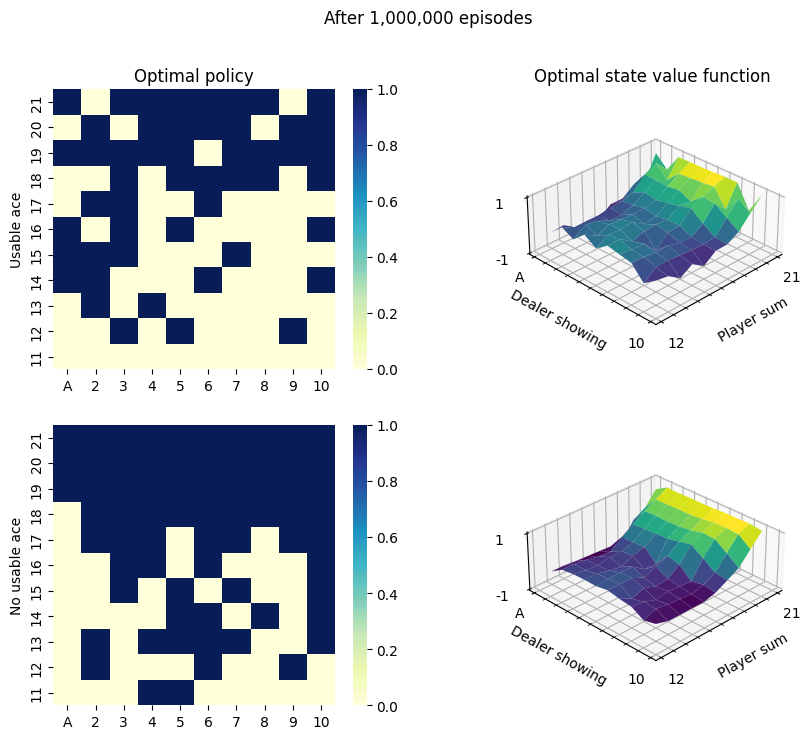

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

state_action_values_usable_ace, state_saction_values_no_ace = state_saction_values[1], state_saction_values[0]
policy_usable_ace = np.argmax(state_action_values_usable_ace, axis=2)
policy_no_ace = np.argmax(state_saction_values_no_ace, axis=2)
state_values_usable_ace = np.max(state_action_values_usable_ace, axis=2)
state_values_no_ace = np.max(state_saction_values_no_ace, axis=2)

policies = [policy_usable_ace, policy_no_ace]
state_values = [state_values_usable_ace, state_values_no_ace]
titles = ['Optimal policy', 'Optimal state value function', '', '']
labels = ['Usable ace', '', 'No usable ace', '']

for i, n in enumerate([0, 2]):
    sub_ax = ax[n//2, n%2]
    plot_figure_heatmap(policies[i], sub_ax, labels[n], titles[n])
for i, n in enumerate([1, 3]):
    sub_ax = ax[n//2, n%2]
    sub_ax.remove()
    sub_ax = fig.add_subplot(2, 2, n + 1, projection='3d')
    plot_figure_3d(state_values[i], sub_ax, labels[n], titles[n])

plt.suptitle('After 1,000,000 episodes')
plt.show()